# Description 

This script allows to generate a timeseries of the mean value of a variable for a lake_id for lakes_cci version 2.1.0


INPUT:
    <ul>
    <li>The identifier of the lake. The id of the lake is indicated 
      in the csv file containing lake metadata. This file is available 
      at the project website:
      https://admin.climate.esa.int/documents/2607/lakescci_v2.1.0_metadata.csv </li>
    <li>Name of the variable in the netCDF files</li>
    <li>Land mask: the netCDF file containing the mask of the lakes in CCI dataset this file 
      is part of the dataset and is available at:
      https://dap.ceda.ac.uk/neodc/esacci/lakes/data/lake_products/L3S/v2.0.1/ESA_CCI_static_lake_mask_v2.0.1.nc</li>
    <li>First/last dates</li>
    <li>Version of the dataset to be download (default value 2.1.0)</li>
    </ul>

 Reference: Carrea, L.; Crétaux, J.-F.; Liu, X.; Wu, Y.; Bergé-Nguyen,
 M.; Calmettes, B.; Duguay, C.; Jiang, D.; Merchant, C.J.; Mueller, D.;
 Selmes, N.; Simis, S.; Spyrakos, E.; Stelzer, K.; Warren, M.; Yesou,
 H.; Zhang, D. (2022): ESA Lakes Climate Change Initiative (Lakes_cci):
 Lake products, Version 2.1.0. NERC EDS Centre for Environmental Data
 Analysis, date of citation.
 https://dx.doi.org/10.5285/7fc9df8070d34cacab8092e45ef276f1
 
    
 WARNING: This script is a beta version. All controls on the input parameters
 are not (yet) available. If you find a bug, have a question or a
 suggestion, don't hesitate to contact us, it will be much appreciated :
 cci_lakes.contact@groupcls.com

 to be executed with python version >= 3.9

# key variables

Lakes_cci dataset is a merged product containing multiple variables from different thematic ECVs. The key variables are as follow:

<b>Lake Water Level (LWL):</b>
<ul><li>water_surface_height_above_reference_datum</li></ul>

<b>Lake Water Extent (LWE):</b>
<ul><li>lake_surface_water_extent</li></ul>

<b>Lake Ice Cover (LIC):</b>
<ul><li>lake_ice_cover_class</li></ul>


<b>Lake Water Extent (LWE):</b>
<ul><li>lake_surface_water_temperature</li></ul>


<b>Lake Water Leaving Reflectance (LWLR):</b>
<ul><li>chla_mean</li>
<li>turbidity_mean</li>
<li>Rwxxx with xxx: 400, 412, 443, 469, 490, 510, 531, 547, 560, 620, 645, 665, 674, 681, 709, 754, 779, 859, Rw885, 900, 1020</li></ul>


In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib widget
%matplotlib inline


In [4]:
###########################################################################################
# input parameters
###########################################################################################   

# lakes mask file 
maskfile = 'ESA_CCI_static_lake_mask_v2.1.nc'

# Id for lake Turkana: 22
lake_id = 22

# variable name
varname = 'lake_surface_water_extent'

# defining the period of time in string format: YYYY-MM-DD
# dates values must be between 1992-09-26 and 2020-12-31

mindate = '2021-07-01'
maxdate = '2021-07-31'

In [5]:
# test if dates are in the temporal coverage

mindate = datetime.datetime.strptime(mindate, '%Y-%m-%d')
maxdate = datetime.datetime.strptime(maxdate, '%Y-%m-%d')
mindate = max([mindate, datetime.datetime(1992,9,26)])
maxdate = min([maxdate, datetime.datetime(2022,12,31)])


In [6]:

###################################################################
# create mask based on lake_id
###################################################################

mask_xr = xr.open_dataset(maskfile)
mask = mask_xr['CCI_lakeid'].values
mask_ind  = np.where(mask == lake_id)
minx = np.min(mask_ind[1][:]) - 1
maxx = np.max(mask_ind[1][:]) + 1
miny = np.min(mask_ind[0][:]) - 1
maxy = np.max(mask_ind[0][:]) + 1

mask_lake = mask[miny:maxy+1, minx:maxx+1]
mask_lake[mask_lake!=lake_id] = 0
mask_lake[mask_lake == lake_id] = 1


Download process: this can take longtime depending on the selected dates. Each daily file needs to be access to verify if there is (or not) data available for the selected lake.

In [7]:
date_vec = []
data_vec = []
version = 2.1

for data_date in np.arange(mindate.toordinal(), maxdate.toordinal()+1):
    current_date = datetime.datetime.fromordinal(data_date)
    date_str = current_date.strftime("%Y%m%d")
    
    #print (f'Downloading data from lake_id {lake_id} -  ESACCI-LAKES-L3S-LK_PRODUCTS-MERGED-{date_str}-fv{version}.0.nc')
   
    path = f'https://data.cci.ceda.ac.uk/thredds/dodsC/esacci/lakes/data/lake_products/L3S/v{version}/merged_product/'
    path += f'{current_date.year}/{current_date.month:02}/'
    path += f'ESACCI-LAKES-L3S-LK_PRODUCTS-MERGED-{date_str}-fv{version}.0.nc?{lake_surface_water_extentvarname}'
  

    dataset = xr.open_dataset(path)
    dataset = dataset.isel(lat=slice(miny, maxy+1), lon=slice(minx, maxx+1))
    units  = dataset[varname].units
    filval = dataset[varname].encoding['_FillValue']
    data = dataset[varname][0,:,:].values
    
    data[mask_lake == 0] = np.nan
    
    # only keep dates with no NaN values
    if np.isnan(data).all() :
        continue

    date_vec.append(date_str)
    data_vec.append(np.nanmean(data))
    

Generate a dataframe with date and data vectors

In [8]:
df = pd.DataFrame({'date': date_vec, f'{varname}': data_vec})
df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d')

Visualisation of the timeseries during the selected period

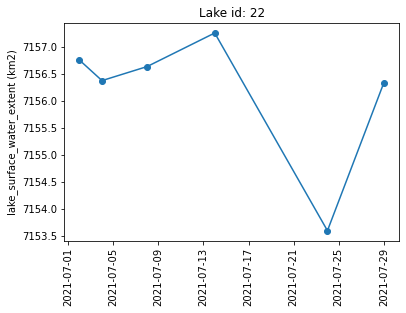

In [9]:
if units == '1' :
    units = 'no units'
plt.plot(df['date'], df[varname], marker='o')
plt.title(f'Lake id: {lake_id}')
plt.ylabel(f'{varname} ({units})')
plt.xticks(rotation=90)
plt.show()

Save time series data in a csv file

In [41]:
df[varname] = np.round(df[varname], 3)
df.to_csv('Turkana_lwe.csv', index = False)